In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math 
import os
import tqdm
import random

import rdkit as rd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AtomPairs
from rdkit import DataStructs
from rdkit import rdBase
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect

import sklearn
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.utils.validation import check_is_fitted

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torcheval
from torcheval.metrics import R2Score

device = "cuda" if torch.cuda.is_available else "cpu"

In [2]:
#This will only import the first sheet within the excel sheet. 
def Data_gather(path: str, file_name: str, CO: bool, drop_phase: bool) -> pd.DataFrame:
    file_path = os.path.join(path, file_name)
    df = pd.read_excel(file_path)

    if CO == True:
        df_CO = df[ df['Isomeric Smile'] != 'CO' ]
        df = df.drop(df_CO.index, axis= 0)
        
    if drop_phase == True:
        df_drop = df[df['Phase'] != 'liquid' ]
        df = df.drop(df_drop.index, axis= 0)
        df = df.drop(['Phase'], axis= 1)
    else:
        df['Phase'] = df['Phase'].map({'liquid': 1, 'vapor': 2})
    
    df = df.reset_index(drop=True)

    #Convert specific column to float64
    #df = pd.to_numeric(df, errors='coerce')
    #df

    #search for any NaN values that may have slipped through the cracks
    #row = df[df['Cp (J/mol*K)'].isnull()]
    #print(row)
    return df

def MoleculeGen(rad: int, df: pd.DataFrame, Choice: bool) -> pd.DataFrame:
    if Choice == True:
        mol_list = []
        fin_list = []
        for smile in df['Isomeric Smile']:
            try:
                mol = Chem.MolFromSmiles(smile)
                mol_list.append(mol)
                mf_bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius=rad, nBits = 256)
                temp_arr = np.zeros((0,), dtype=np.int8)
                DataStructs.ConvertToNumpyArray(mf_bitvect, temp_arr)
                fin_list.append(temp_arr)
            except:
                print(smile)
        fin_list = pd.DataFrame(fin_list)
        df = pd.concat([df, fin_list], axis= 1)
    df = df.drop(['Isomeric Smile'], axis= 1)
    return df

def Data_Manipulation(df: pd.DataFrame) -> pd.DataFrame:    
    Temperature = df['Temperature (K)'].values
    Pressure = df['Pressure (bar)'].values
    Tc = df['Tc'].values
    Pc = df['Pc'].values
    CP = df['Cp (J/mol*K)'].values
    Isom = df['Isomeric Smile'].values
    df = df.drop(['Isomeric Smile', 'Density (kg/m3)', 'Temperature (K)', 'Pressure (bar)', 'Cp (J/mol*K)', 'Tc', 'Pc'], axis= 1)
    
    Tr = Temperature/Tc
    Pr = Pressure/Pc

    temp = {'Isomeric Smile': Isom, 'Tr': Tr, 'Pr': Pr, 'Cp': CP}
    temp = pd.DataFrame(temp)
    df_drop = temp[temp['Tr'] >= 0.999]
    temp = temp.drop(df_drop.index, axis= 0)
    df_drop = temp[temp['Pr'] >= 0.999]
    temp = temp.drop(df_drop.index, axis= 0)
    temp = temp.reset_index(drop=True)

    Isom = temp['Isomeric Smile'].values
    Tr = temp['Tr'].values
    Pr = temp['Pr'].values 
    CP = temp['Cp'].values

    Temperature = np.power(np.arctanh(np.power(Tr, 29.12522)), 0.688902)
    Pressure = np.power(np.arctanh(np.power(Pr, 0.99928)), 1.162695504)
    CP = np.sqrt(np.log(np.power(np.log(CP), 1/3.061115817107)))
    
    temp = {'Isomeric Smile': Isom, 'Temperature (K)': Temperature, 'Pressure (bar)': Pressure, 'Cp (J/mol*K)': CP}
    temp = pd.DataFrame(temp)
        
    return temp

In [3]:
class ANN(nn.Module):
    def __init__(self, in_count, out_count):
        super().__init__()
        self.Linear_1 = nn.Linear(in_count, 29)
        self.Linear_2 = nn.Linear(29, out_count)

    def forward(self, x):
        x = F.relu(self.Linear_1(x))
        return self.Linear_2(x)

In [4]:
dataframe = Data_gather(r"C:\Users\Geoff's\Desktop\Dissertation\Models\No Cross Validation", "NIST 7.xlsx", False, True)
dataframe = Data_Manipulation(dataframe)
dataframe = MoleculeGen(5, dataframe, True)
targets = ['Cp (J/mol*K)']
features = (list(set(list(dataframe.columns))-set(targets)))
x_data = dataframe[features].values
y_data = dataframe[targets].values

In [5]:
x = torch.Tensor(x_data).float()
y = torch.Tensor(y_data).float()
model2 = ANN(x_data.shape[1],1).to(device)
path = r"C:\Users\Geoff's\Desktop\Dissertation\Models\No Cross Validation\Final_model.pth"
model2.load_state_dict(torch.load(path))
model2.eval()
pred = model2(x.to(device))
R2_score = R2Score()
R2_score.update(pred.to(device), y.to(device))
score = R2_score.compute()
MSE = mean_squared_error(pred.cpu().detach(), y.cpu())
RMSE = np.sqrt(MSE)
print(f"Final score (R^2): {score:.5f}")
print(f"Final score (MSE): {MSE:.5}")
print(f"Final score (RMSE): {RMSE:.7f}")

Final score (R^2): 0.90413
Final score (MSE): 4.1942e-05
Final score (RMSE): 0.0064763


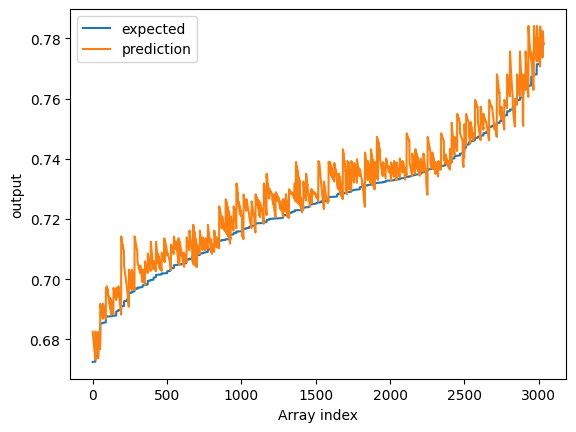

In [6]:
t = pd.DataFrame({'pred': pred.cpu().detach().numpy().tolist(), 'y': y.cpu().numpy().tolist()})
t = t.sort_values(['y'])
plt.plot(t['y'].tolist(), label= 'expected')
plt.plot(t['pred'].tolist(), label= 'prediction')
plt.ylabel('output')
plt.xlabel('Array index')
#plt.savefig('Final_model_optimised_output.pdf')
plt.legend()
plt.show()

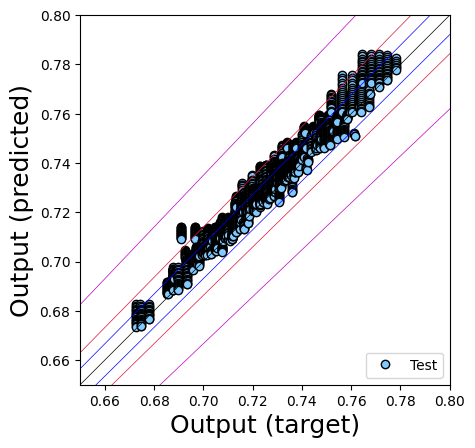

In [7]:
ax1=plt.subplot(1, 1, 1)

#ax1.plot(y_train,predict_train_set,marker='o',ls='None',mec='k',mfc='#FF908C',label='Train')
ax1.plot(t['y'].tolist(),t['pred'].tolist(),marker='o',ls='None',mec='k',mfc='#80CAFF',label='Test')
ax1.legend(loc= 4)

ax1.plot([0,1000], [0,1000], '-k', lw=0.5)

#1% scatter bands
ax1.plot([0,1000], [0,1010], 'b', lw=0.5)
ax1.plot([0,1010], [0,1000], 'b', lw=0.5)
ax1.annotate(f'1% scatter band', xy=(1.55, 1.54), xytext=(1.65, 1.54),
            arrowprops=dict(facecolor='black', shrink=0.1, width= 0.1, headwidth= 5),
            )


#2% scatter bands
ax1.plot([0,1000], [0,1020], 'crimson', lw=0.5)
ax1.plot([0,1020], [0,1000], 'crimson', lw=0.5)
ax1.annotate(f'2% scatter band', xy=(1.6, 1.578), xytext=(1.7, 1.578),
            arrowprops=dict(facecolor='black', shrink=0.1, width= 0.1, headwidth= 5),
            )

#5% scatter bands
ax1.plot([0,1000], [0,1050], 'm', lw=0.5)
ax1.plot([0,1050], [0,1000], 'm', lw=0.5)
ax1.annotate(f'5% scatter band', xy=(1.7, 1.63), xytext=(1.8, 1.63),
            arrowprops=dict(facecolor='black', shrink=0.1, width= 0.1, headwidth= 5),
            )


# inset_axis = inset_axes(ax1, 
#                     width="50%",
#                     height=1.4, 
#                     bbox_to_anchor=(.1, .475, .6, .5),
#                     bbox_transform=ax1.transAxes, loc='upper left')

# inset_axis_actual_values = sorted(y_test)
# inset_axis_pred_values = sorted(predict_test_set)
# inset_axis.plot(inset_axis_actual_values, inset_axis_pred_values, 'ok')
# inset_axis.plot([0,1000], [0,1000], '-k', lw=0.5)

# #1% scatter bands
# inset_axis.plot([0,1000], [0,1010], 'b', lw=0.5)
# inset_axis.plot([0,1010], [0,1000], 'b', lw=0.5)
# #2% scatter bands
# inset_axis.plot([0,1000], [0,1020], 'crimson', lw=0.5)
# inset_axis.plot([0,1020], [0,1000], 'crimson', lw=0.5)


# inset_axis.set_xlim([1.615,1.67])
# inset_axis.set_ylim([1.615,1.67])

ax1.set_xlim([0.65,0.8])
ax1.set_ylim([0.65,0.8])
ax1.set_xlabel('Output (target)',size=18)
ax1.set_ylabel('Output (predicted)',size=18)
plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('Final_model_optimised_expected_vs_predicted.pdf')

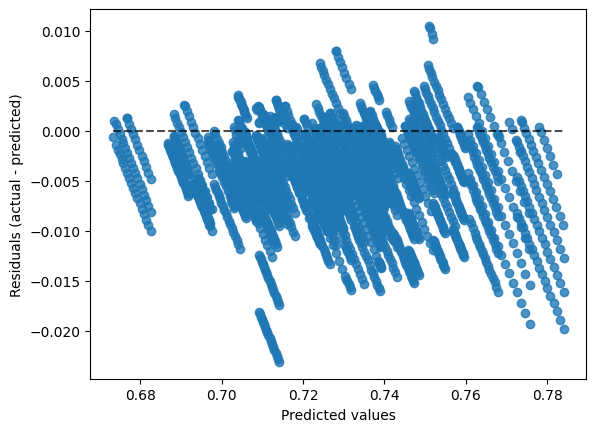

In [8]:
display = PredictionErrorDisplay(y_true= y.cpu().detach().numpy(), y_pred= pred.cpu().detach().numpy())
display.plot()
#plt.savefig('Final_model_optimised_residue.pdf')
plt.show()

In [10]:

np.exp(-13)

2.2603294069810542e-06